# 2023 Evil Geniuses' Data Science Take-Home Assessment

## About
* **Author:** Jesus Rafael Rijo Candelario
* **Date:** 05/28/2023
* **Description:** Jupyter notebook to perform Evil Geniuses' DS take-home assessment.

## Instructions

* For this assessment, we’d like to see how you approach discovery, problem solving, and communication for a data science project. Attempt to solve the following problem on the provided dataset using Python (no restrictions on package usage):
* You’re given a dataset of Starcraft player performance data in ranked games. We want to develop a model to predict a player’s rank using the information provided in the dataset.
* Document your decision making throughout the model building process (EDA, ETL, modeling, evaluation, etc).
	* Try to functionize any repetitive tasks so that the workflow is simplified.
* Once you’ve settled on your model, communicate your findings to non-technical stakeholders.
* Hypothetical: after seeing your work, your stakeholders come to you and say that they can collect more data, but want your guidance before starting. How would you advise them based on your EDA and model results?

# Part 0: External Modules and Helper Function(s)

* This section will contain and describe the modules and helper functions used across the assessment.
* I invoked`os`to check for the existence of a given CSV file.
* `pandas`and`numpy` facilitate data storage and wrangling throughout the project.
* `matplotlib`and`seaborn` enable data visualization, particularly for the project's EDA.
* `sklearn` covers the modeling portion of the assessment.

In [44]:
# Built-in and external Python modules.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, recall_score

# A command to instruct our Python environment to display plots right after the 
%matplotlib inline

In [45]:
"""
Function to load and preprocess CSV file.

This function will shutdown the notebook's workflow if the CSV does not exist.
"""
def load_csv( filename ):
    # Reading data from CSV file.
    if os.path.exists(filename):
        dataset = pd.read_csv(filename, header = 0)
    else:
        print("ERROR: CSV file does not exist.")
        quit()

    # Dropping non-numeric values. NOTE: I noticed that a few rows (along the dataset's end) 
    # had question marks instead of numeric values.
    for col in dataset.columns.values:
        dataset = dataset[pd.to_numeric(dataset[col], errors='coerce').notnull()]

    # Dropping duplicates and rows with missing entries.
    dataset = dataset.drop_duplicates()
    dataset = dataset.dropna()

    # Converting any non-numeric values into numbers.
    dataset = dataset.apply(pd.to_numeric, errors='ignore')

    return dataset

# Part 1: Loading Data and Preliminary Data Cleaning

* We will start by first loading the CSV file (`starcraft_player_data.csv`) into a Pandas DataFrame.
	* Although we assume that the CSV should always be in the same directory as this Jupyter notebook, we still check for the file existence before executing other cells.
* We will also perform some basic data cleaning to ensure the data fits the provided data dictionary.
* Please refer to `load_data()` to understand the scope of our preliminary data cleaning.
* We noticed that the initial CSV file had **3397** rows, whereas our cleaned dataset has **3338** rows.
	* We beileve this happens because certain entrries are missing entries (denoted with question marks).


In [46]:
# Loading and cleaning data from CSV file.
dataset = load_csv("starcraft_player_data.csv")
print("Number of rows after initial data cleaning: ", len(dataset))
print( dataset.shape )
dataset.head()

Number of rows after initial data cleaning:  3338
(3338, 20)


,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


# Part 2: Exploratory Data Analysis (EDA)


* Through this EDA, we intend to gauge potentially important properties about the dataset.
* Notice that we use `dataset.loc[:, dataset.columns!='GameID']` to ignore the IDs, as they should not affect the other metrics. 


## Part 2.1: Univariate Descriptive Statistics

* The following summarize univariate descriptive statistics about the data.
* We can see that the dataset contains several outliers, such as a player with about 3000 hours played.

In [47]:
# Printing the datatypes of each feature to check they match the given data dictionary.
print(dataset.dtypes)

GameID                    int64
LeagueIndex               int64
Age                       int64
HoursPerWeek              int64
TotalHours                int64
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object


In [48]:
# Printing univariate descriptive statistics about our dataset.
dataset.describe(include ='all')

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000
mean,4719.552127,4.120731,21.650389,15.909527,960.421809,114.575763,0.004023,0.000364,4.316357,0.000094,0.000380,0.003433,40.713819,64.209584,5.266955,22.116836,0.001031,6.541043,0.000060,0.000142
std,2656.919630,1.448170,4.206357,11.964495,17318.133922,48.111912,0.004726,0.000210,2.333322,0.000159,0.000359,0.000966,17.057191,19.037394,1.500605,7.440875,0.000520,1.859049,0.000112,0.000266
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2423.250000,3.000000,19.000000,8.000000,300.000000,79.231500,0.001245,0.000202,3.000000,0.000000,0.000139,0.002743,29.326600,50.886425,4.261525,17.000000,0.000682,5.000000,0.000000,0.000000
50%,4788.000000,4.000000,21.000000,12.000000,500.000000,107.070300,0.002445,0.000349,4.000000,0.000039,0.000278,0.003376,37.058900,61.296100,5.087050,22.000000,0.000904,6.000000,0.000000,0.000020
75%,6994.750000,5.000000,24.000000,20.000000,800.000000,140.156100,0.004945,0.000493,6.000000,0.000113,0.000508,0.004003,48.510425,74.032525,6.027350,27.000000,0.001258,8.000000,0.000087,0.000182
max,9271.000000,7.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


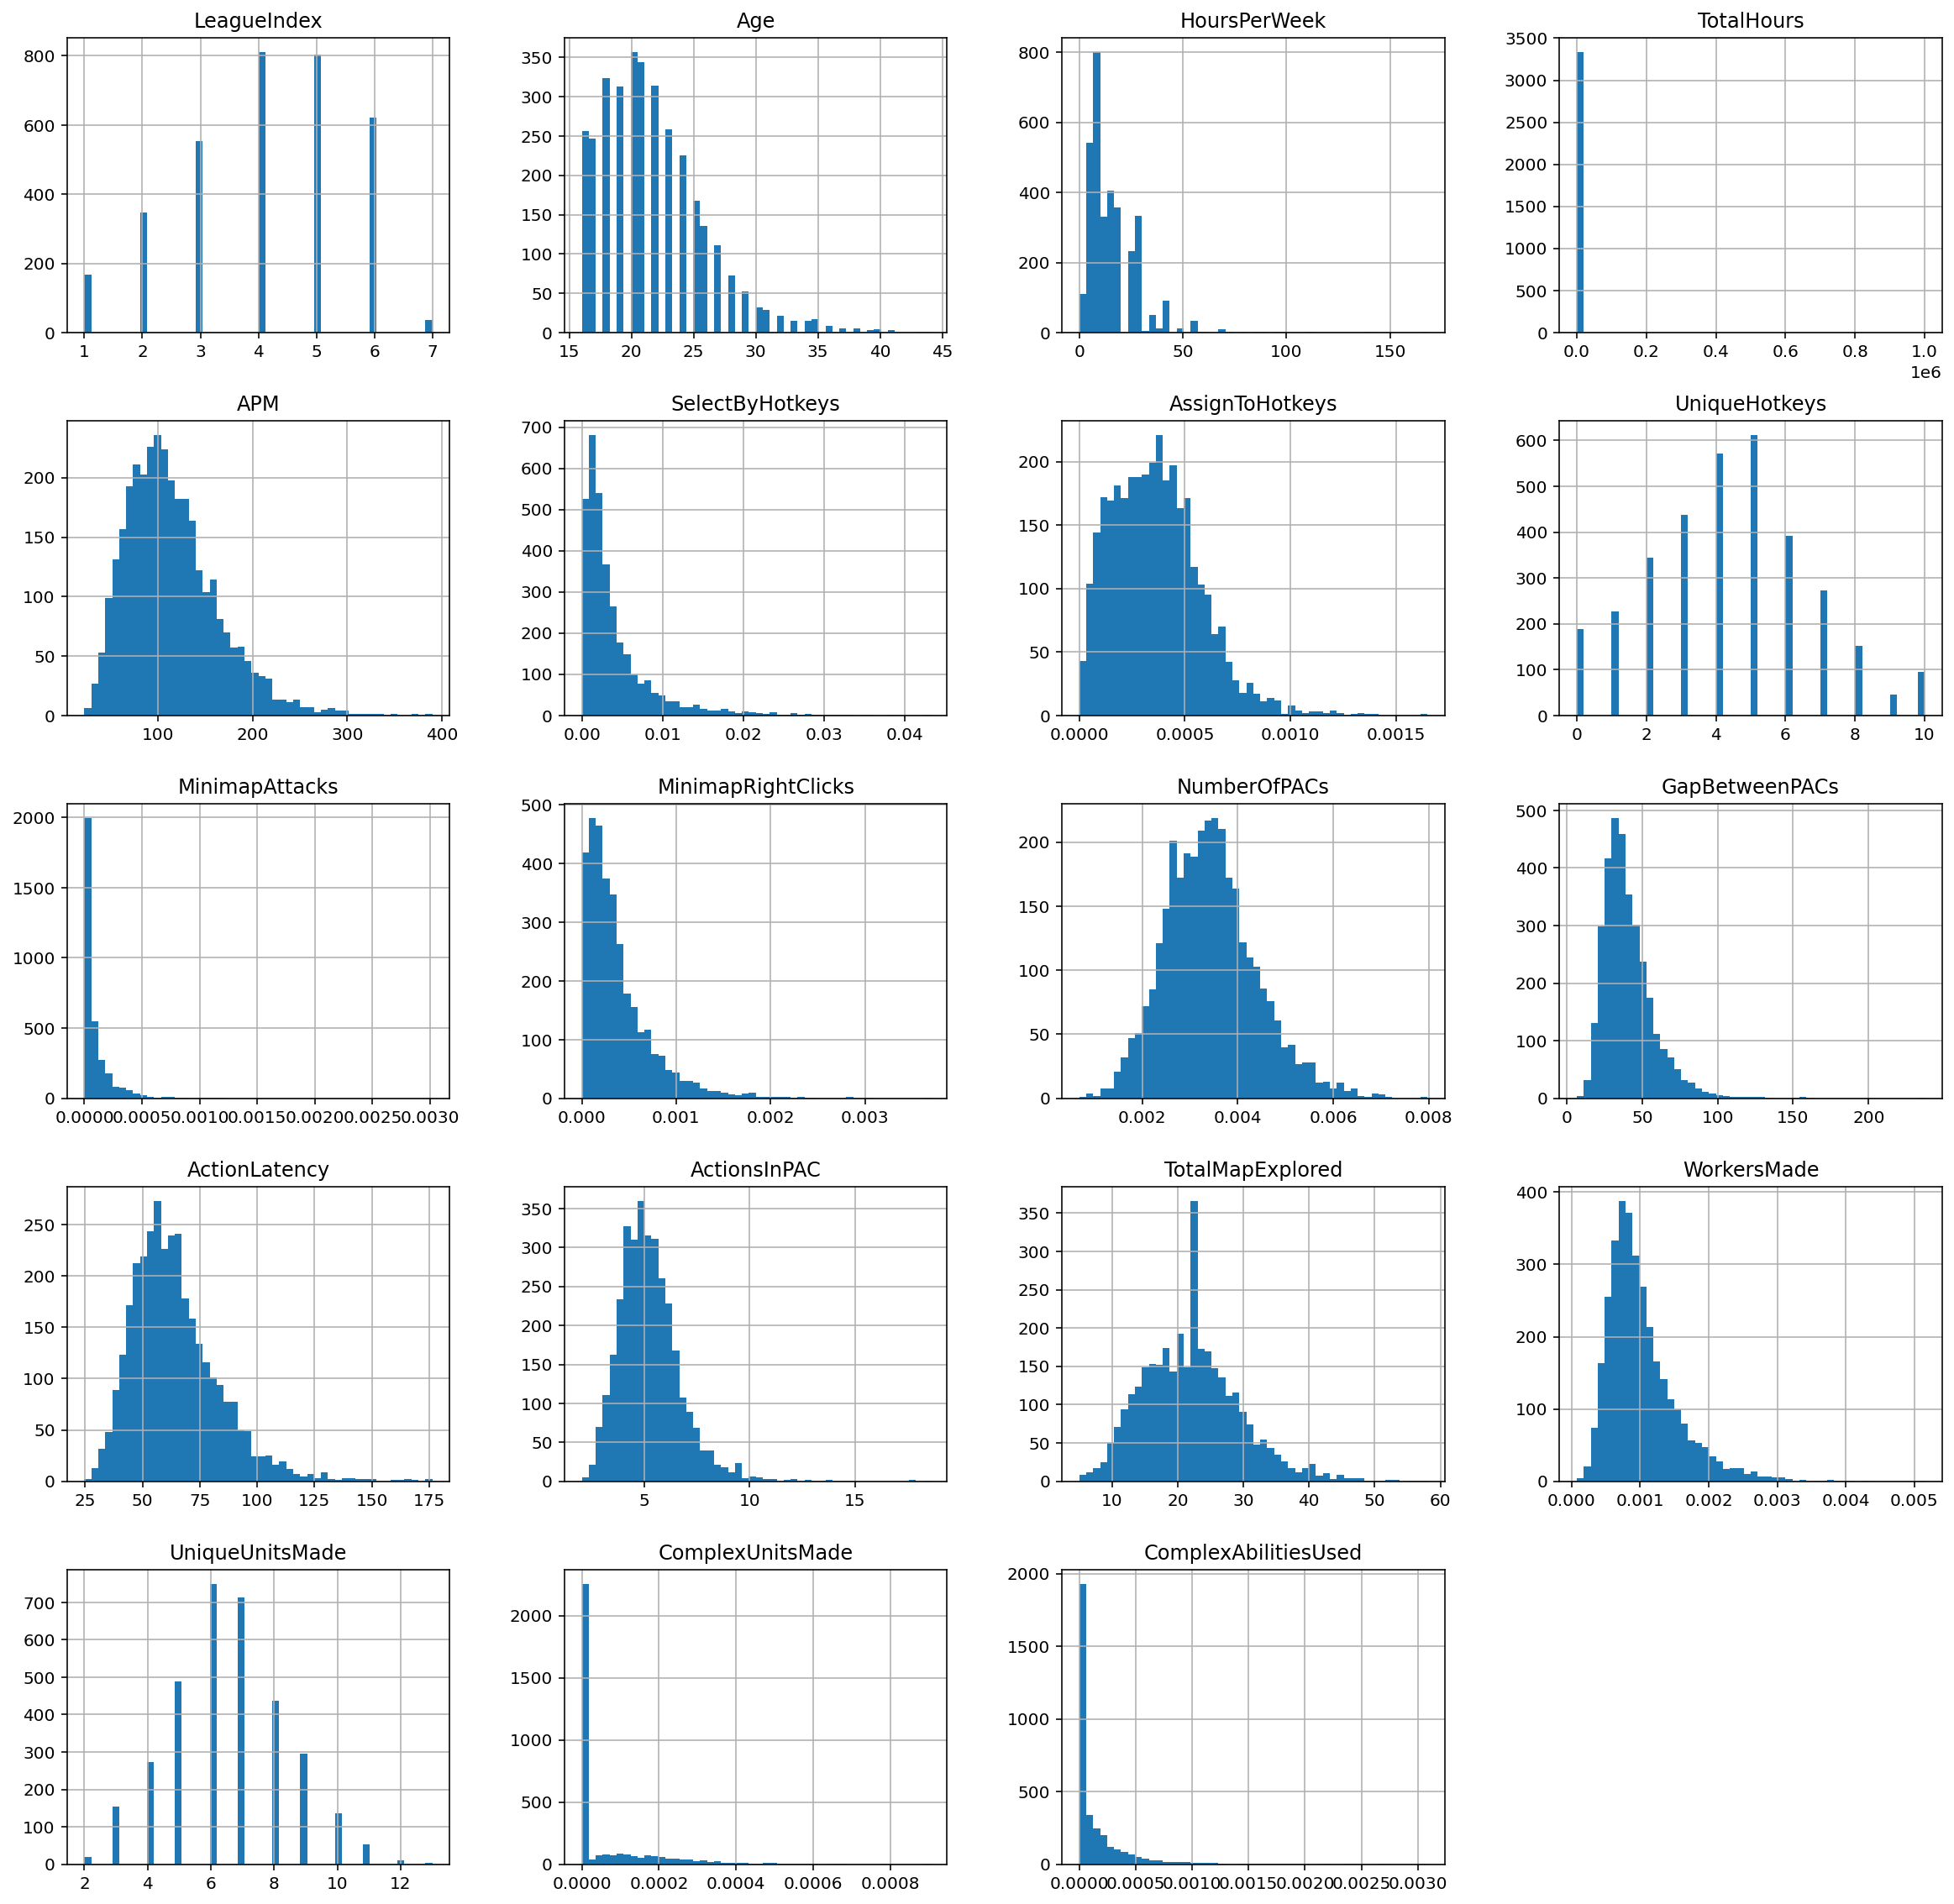

In [49]:
# Drawing the histograms of all the columns but the GameID.
dataset.loc[:, dataset.columns!='GameID'].hist( bins=50, figsize=(20,20) )
plt.show()

<Axes: >

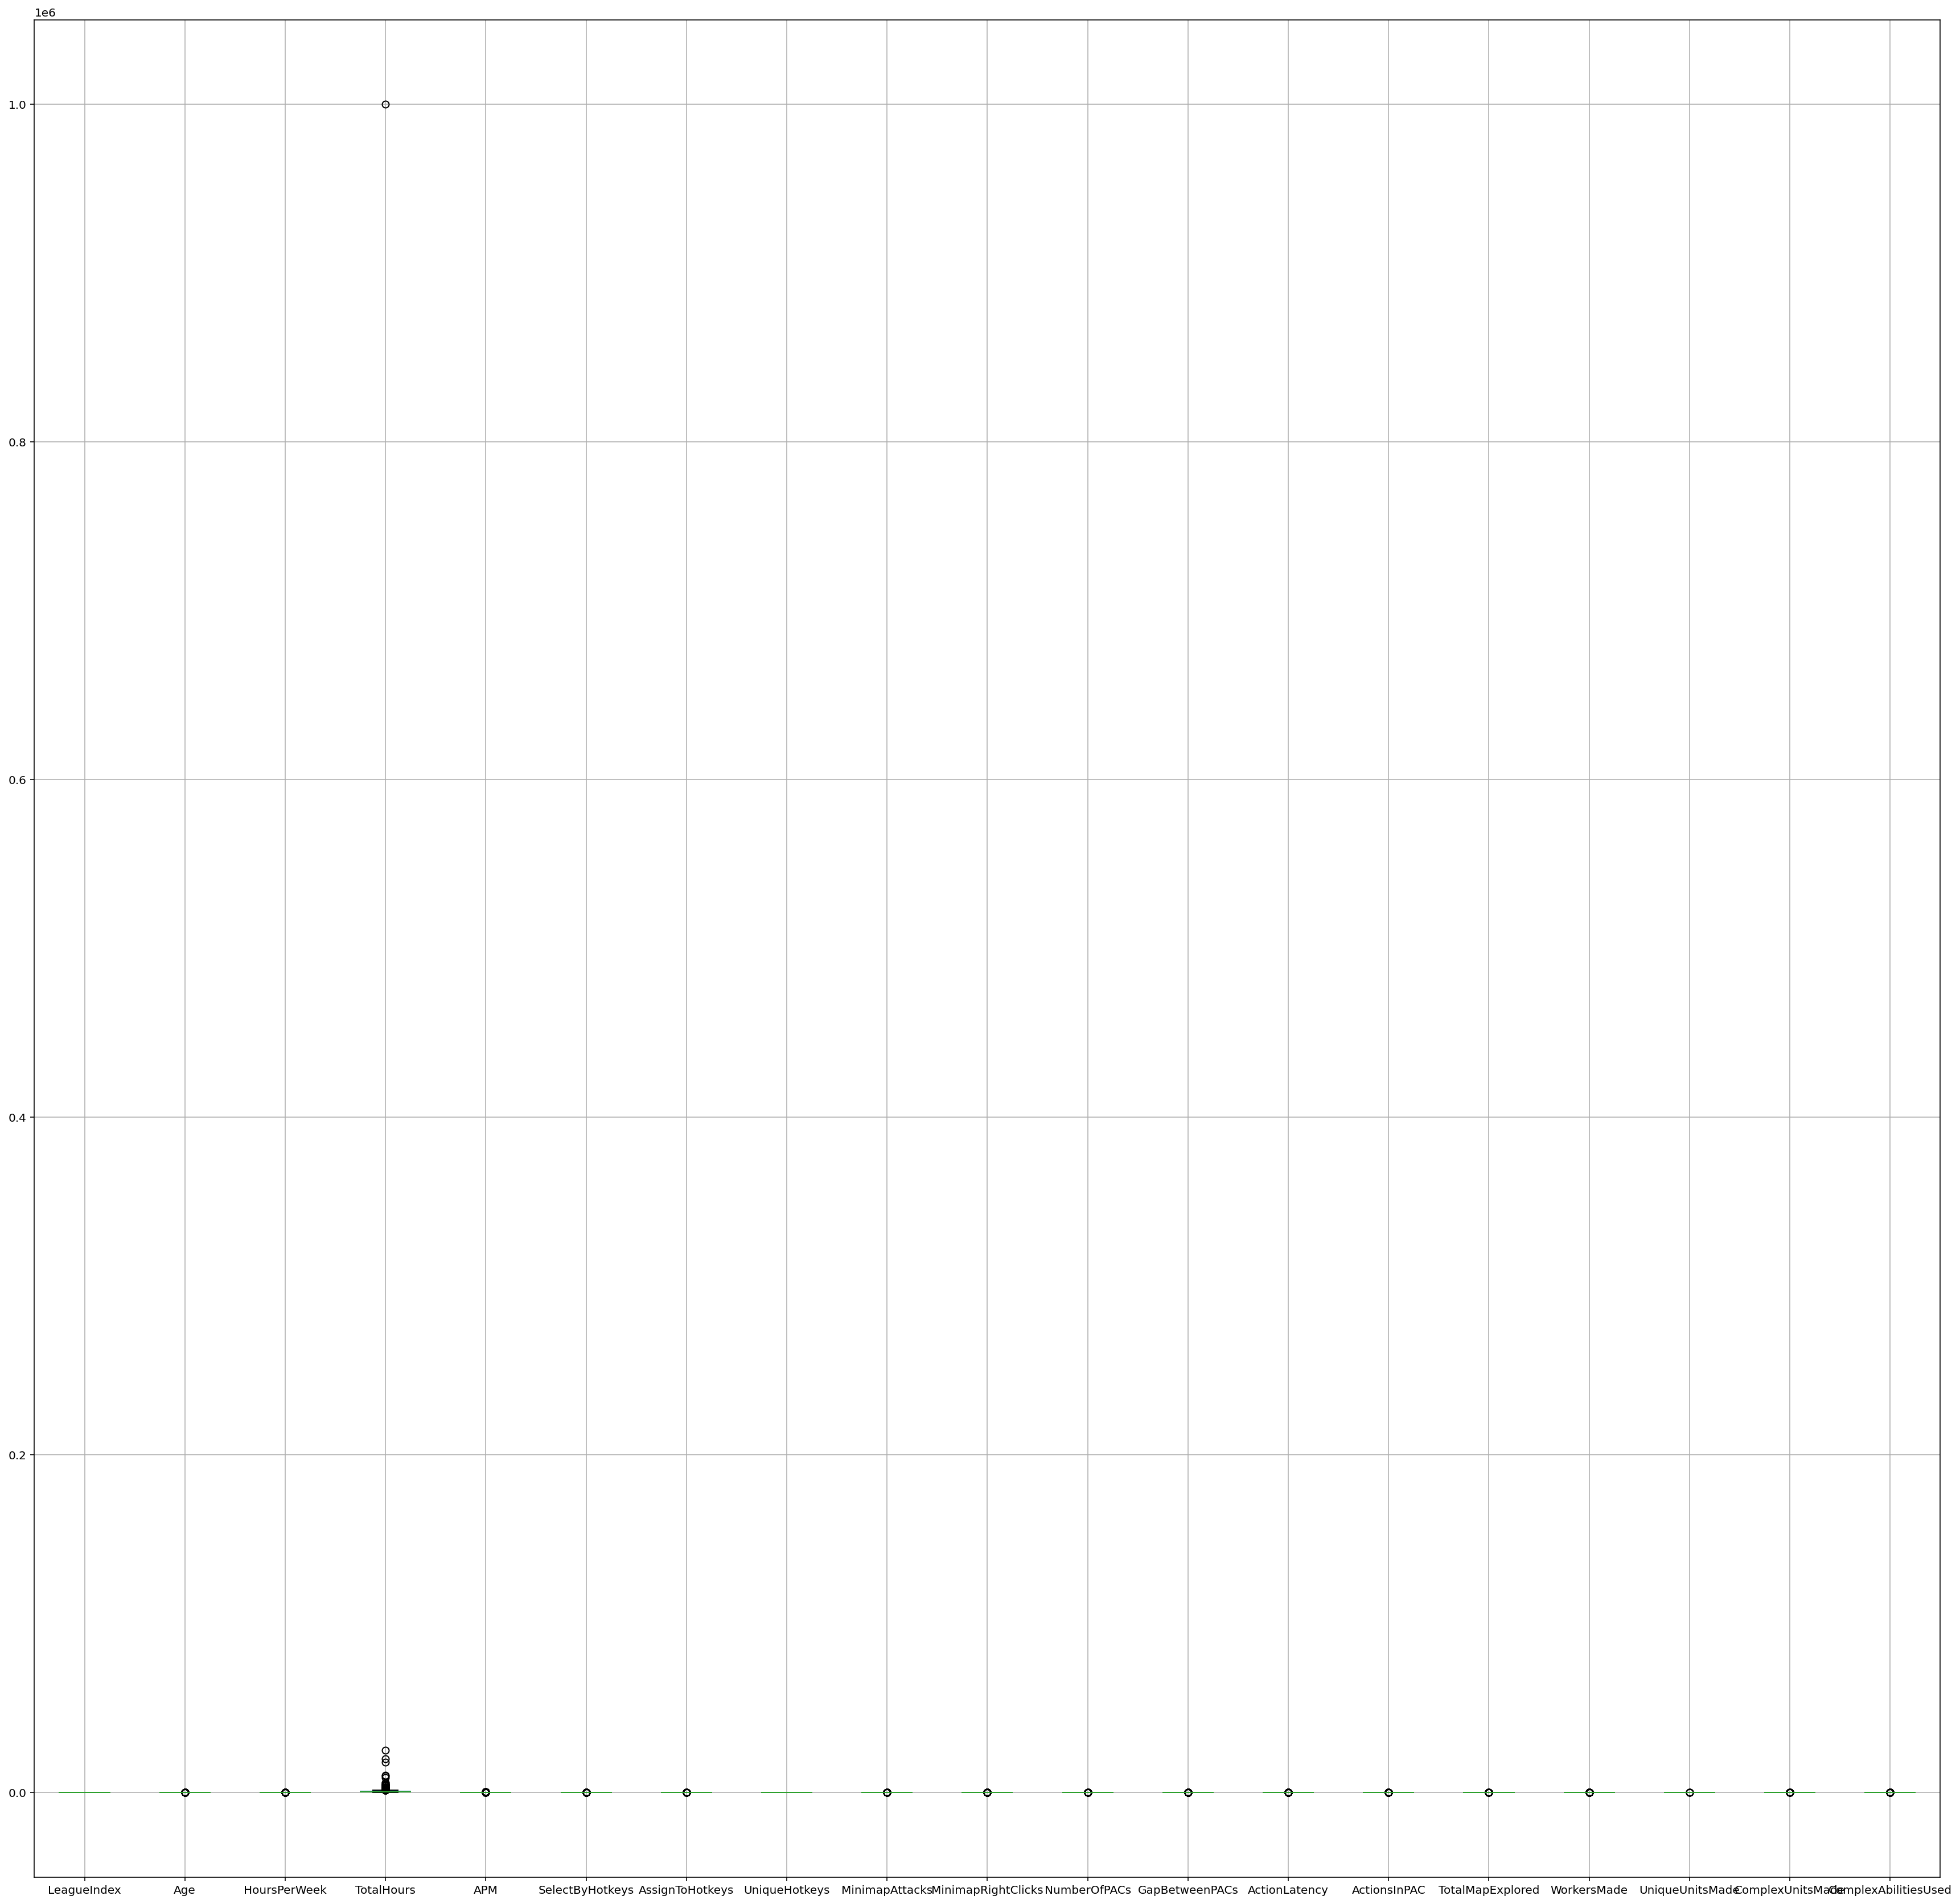

In [50]:
# A boxplot to detect any missed outliers.
plt.figure(figsize=(30,30))
dataset.loc[:, dataset.columns!='GameID'].boxplot()

## Part 2.2: Assessing Class Imbalance(s)

* We can see various noticeable class imbalances in our dataset.
* Specifically, we noticed our dataset does not have any entries for players in the Grandmaster and Professional ranks.
* However, many sources do indicate that highly-ranked players represent a smaller portion of the total playing population, such as [Liquipedia](https://liquipedia.net/starcraft2/Battle.net_Leagues).

ERROR: The following is not available in the dataset: 8


<Axes: xlabel='ranks', ylabel='count'>

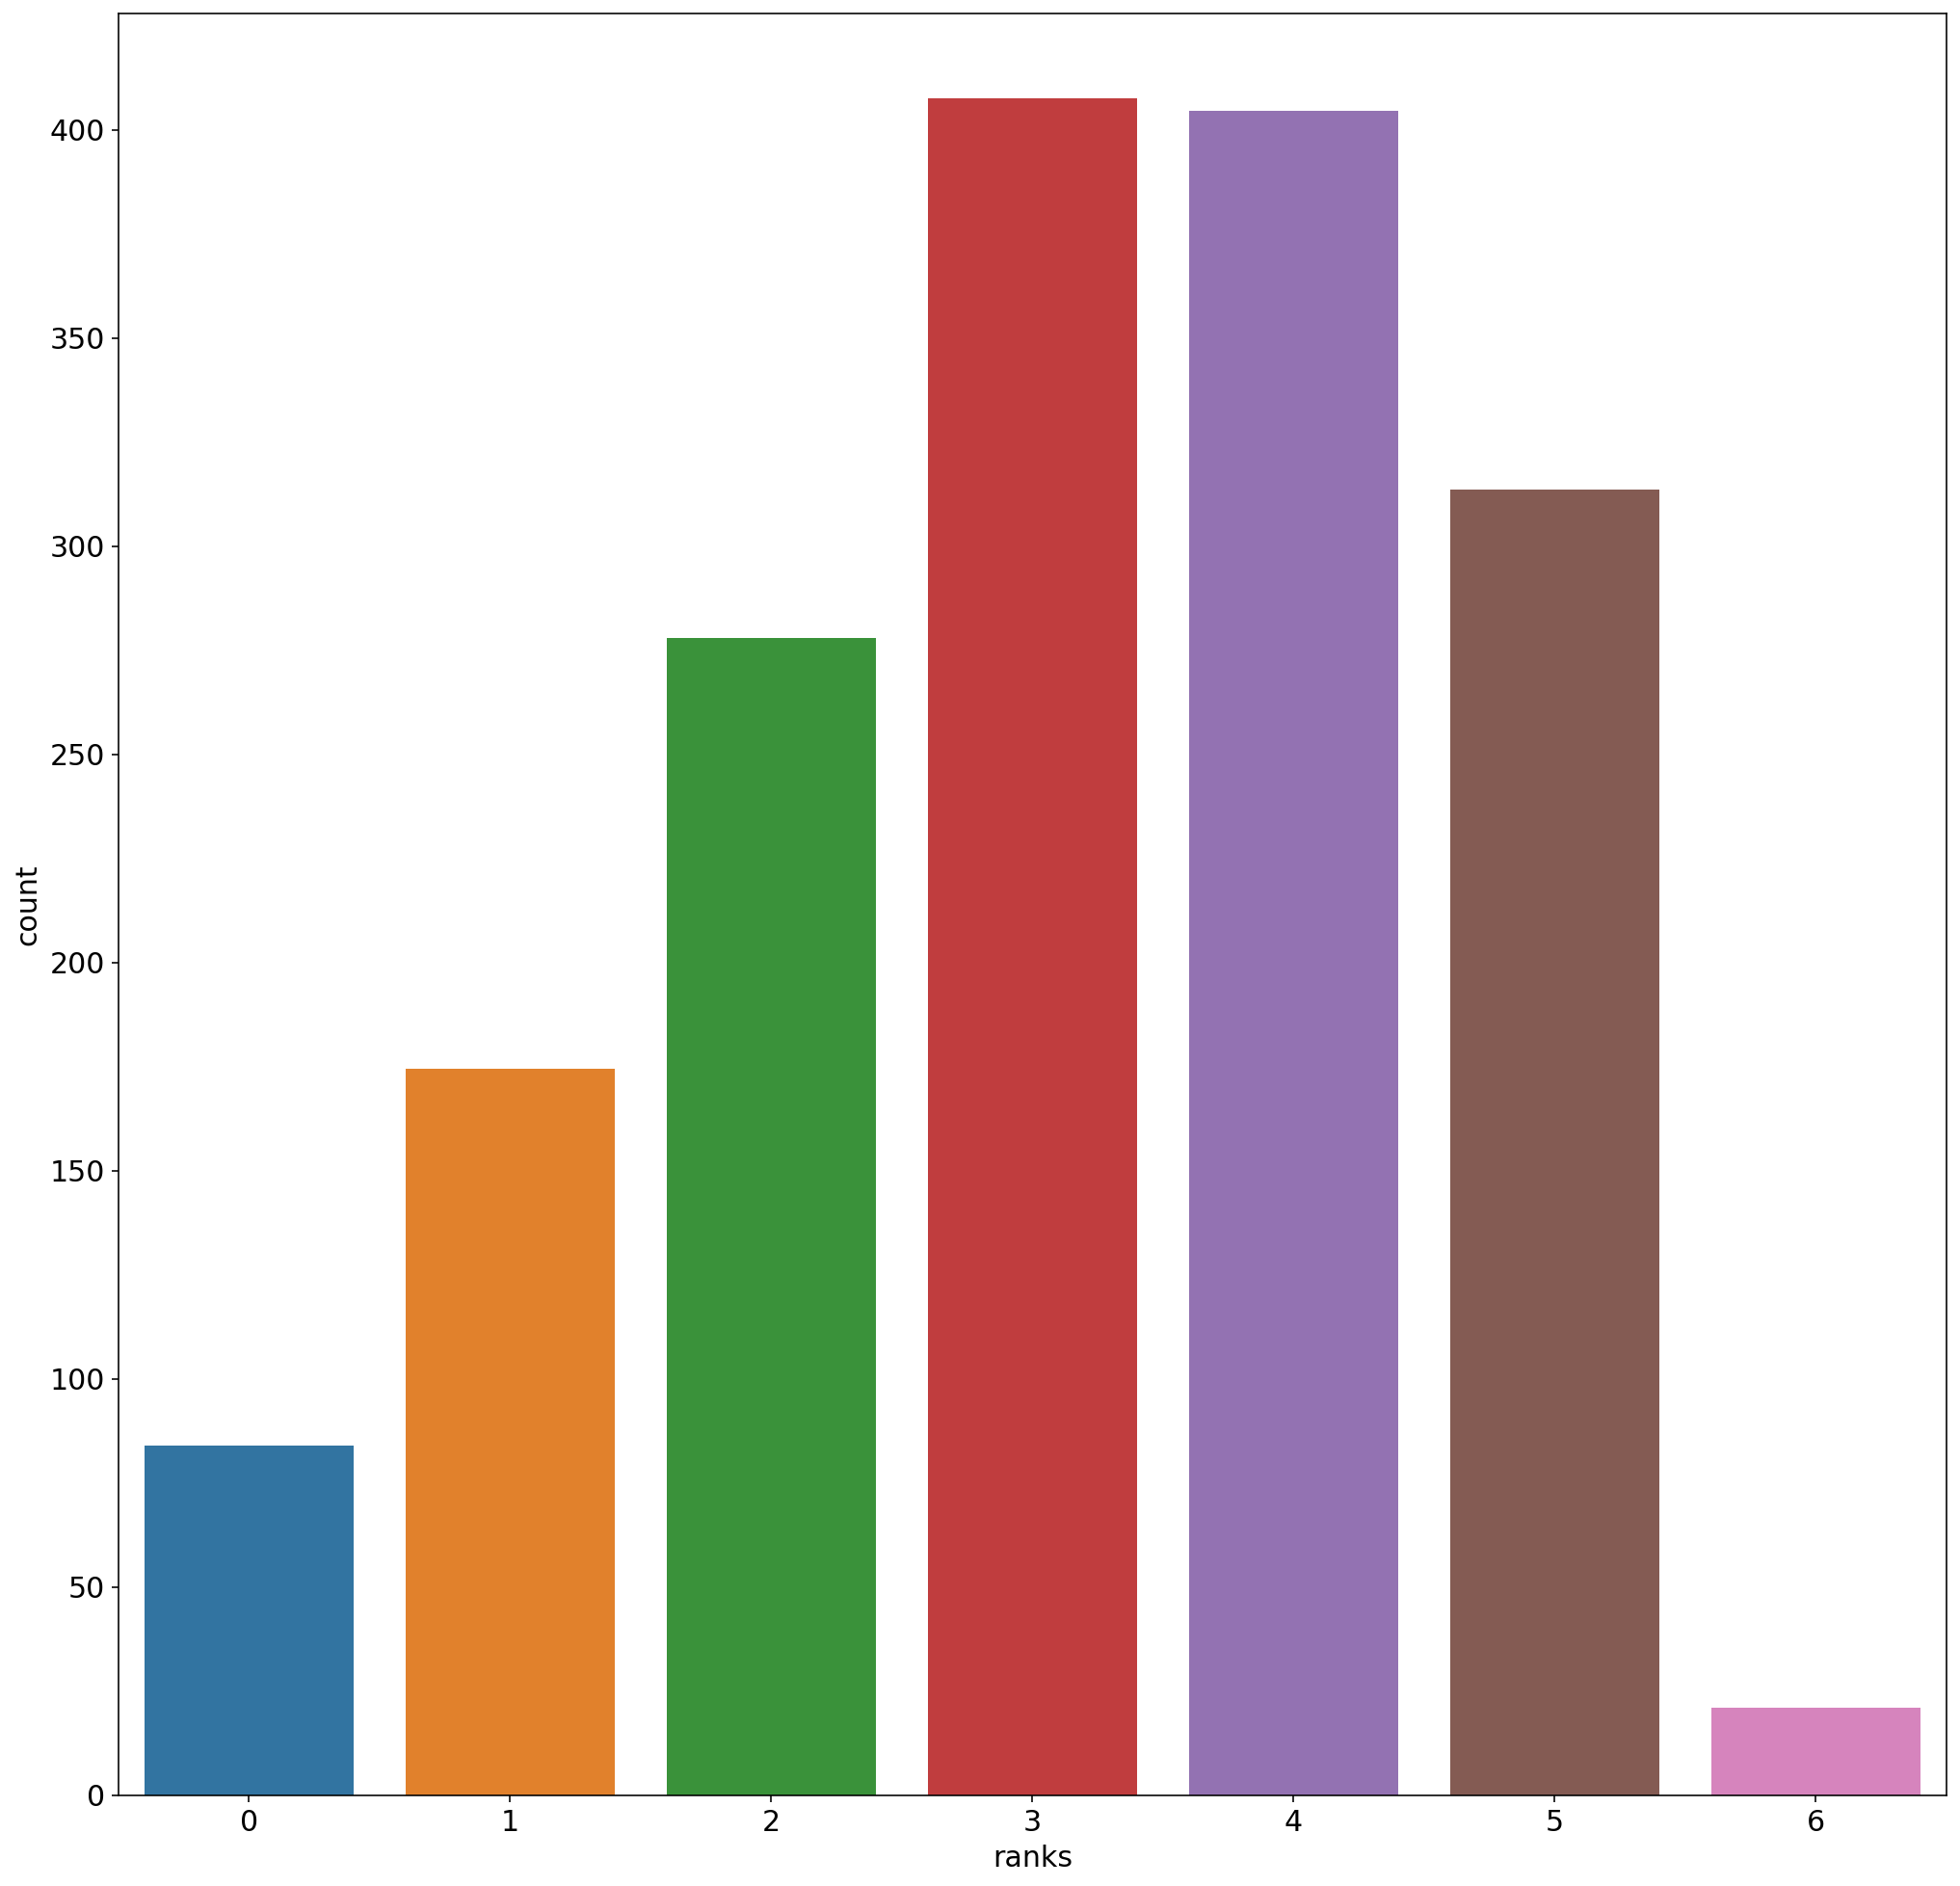

In [51]:
# Retrieving counts of each rank.
rank_freq = []
freq_counts = dataset.value_counts('LeagueIndex')

# Placing ranks and their counts into a list of ordered pairs for plotting.
for i in range(1,9):
    try:
        rank_freq.append([i,freq_counts[i]])
    except:
        print('ERROR: The following is not available in the dataset:', i)

# Plotting count against ranks.
plt.figure(figsize=(17,17))
plt.xlabel('ranks',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.tick_params(labelsize=15)
sns.barplot(data=rank_freq, errorbar=('ci', 0))

## Part 2.3: Heatmaps

* It seems that most attributes are negatively related to the number of **percception action cycles (PACs)** and **action latency**.
* Other noticeable strong correlations include **age** and the **total hours** played.

<Axes: >

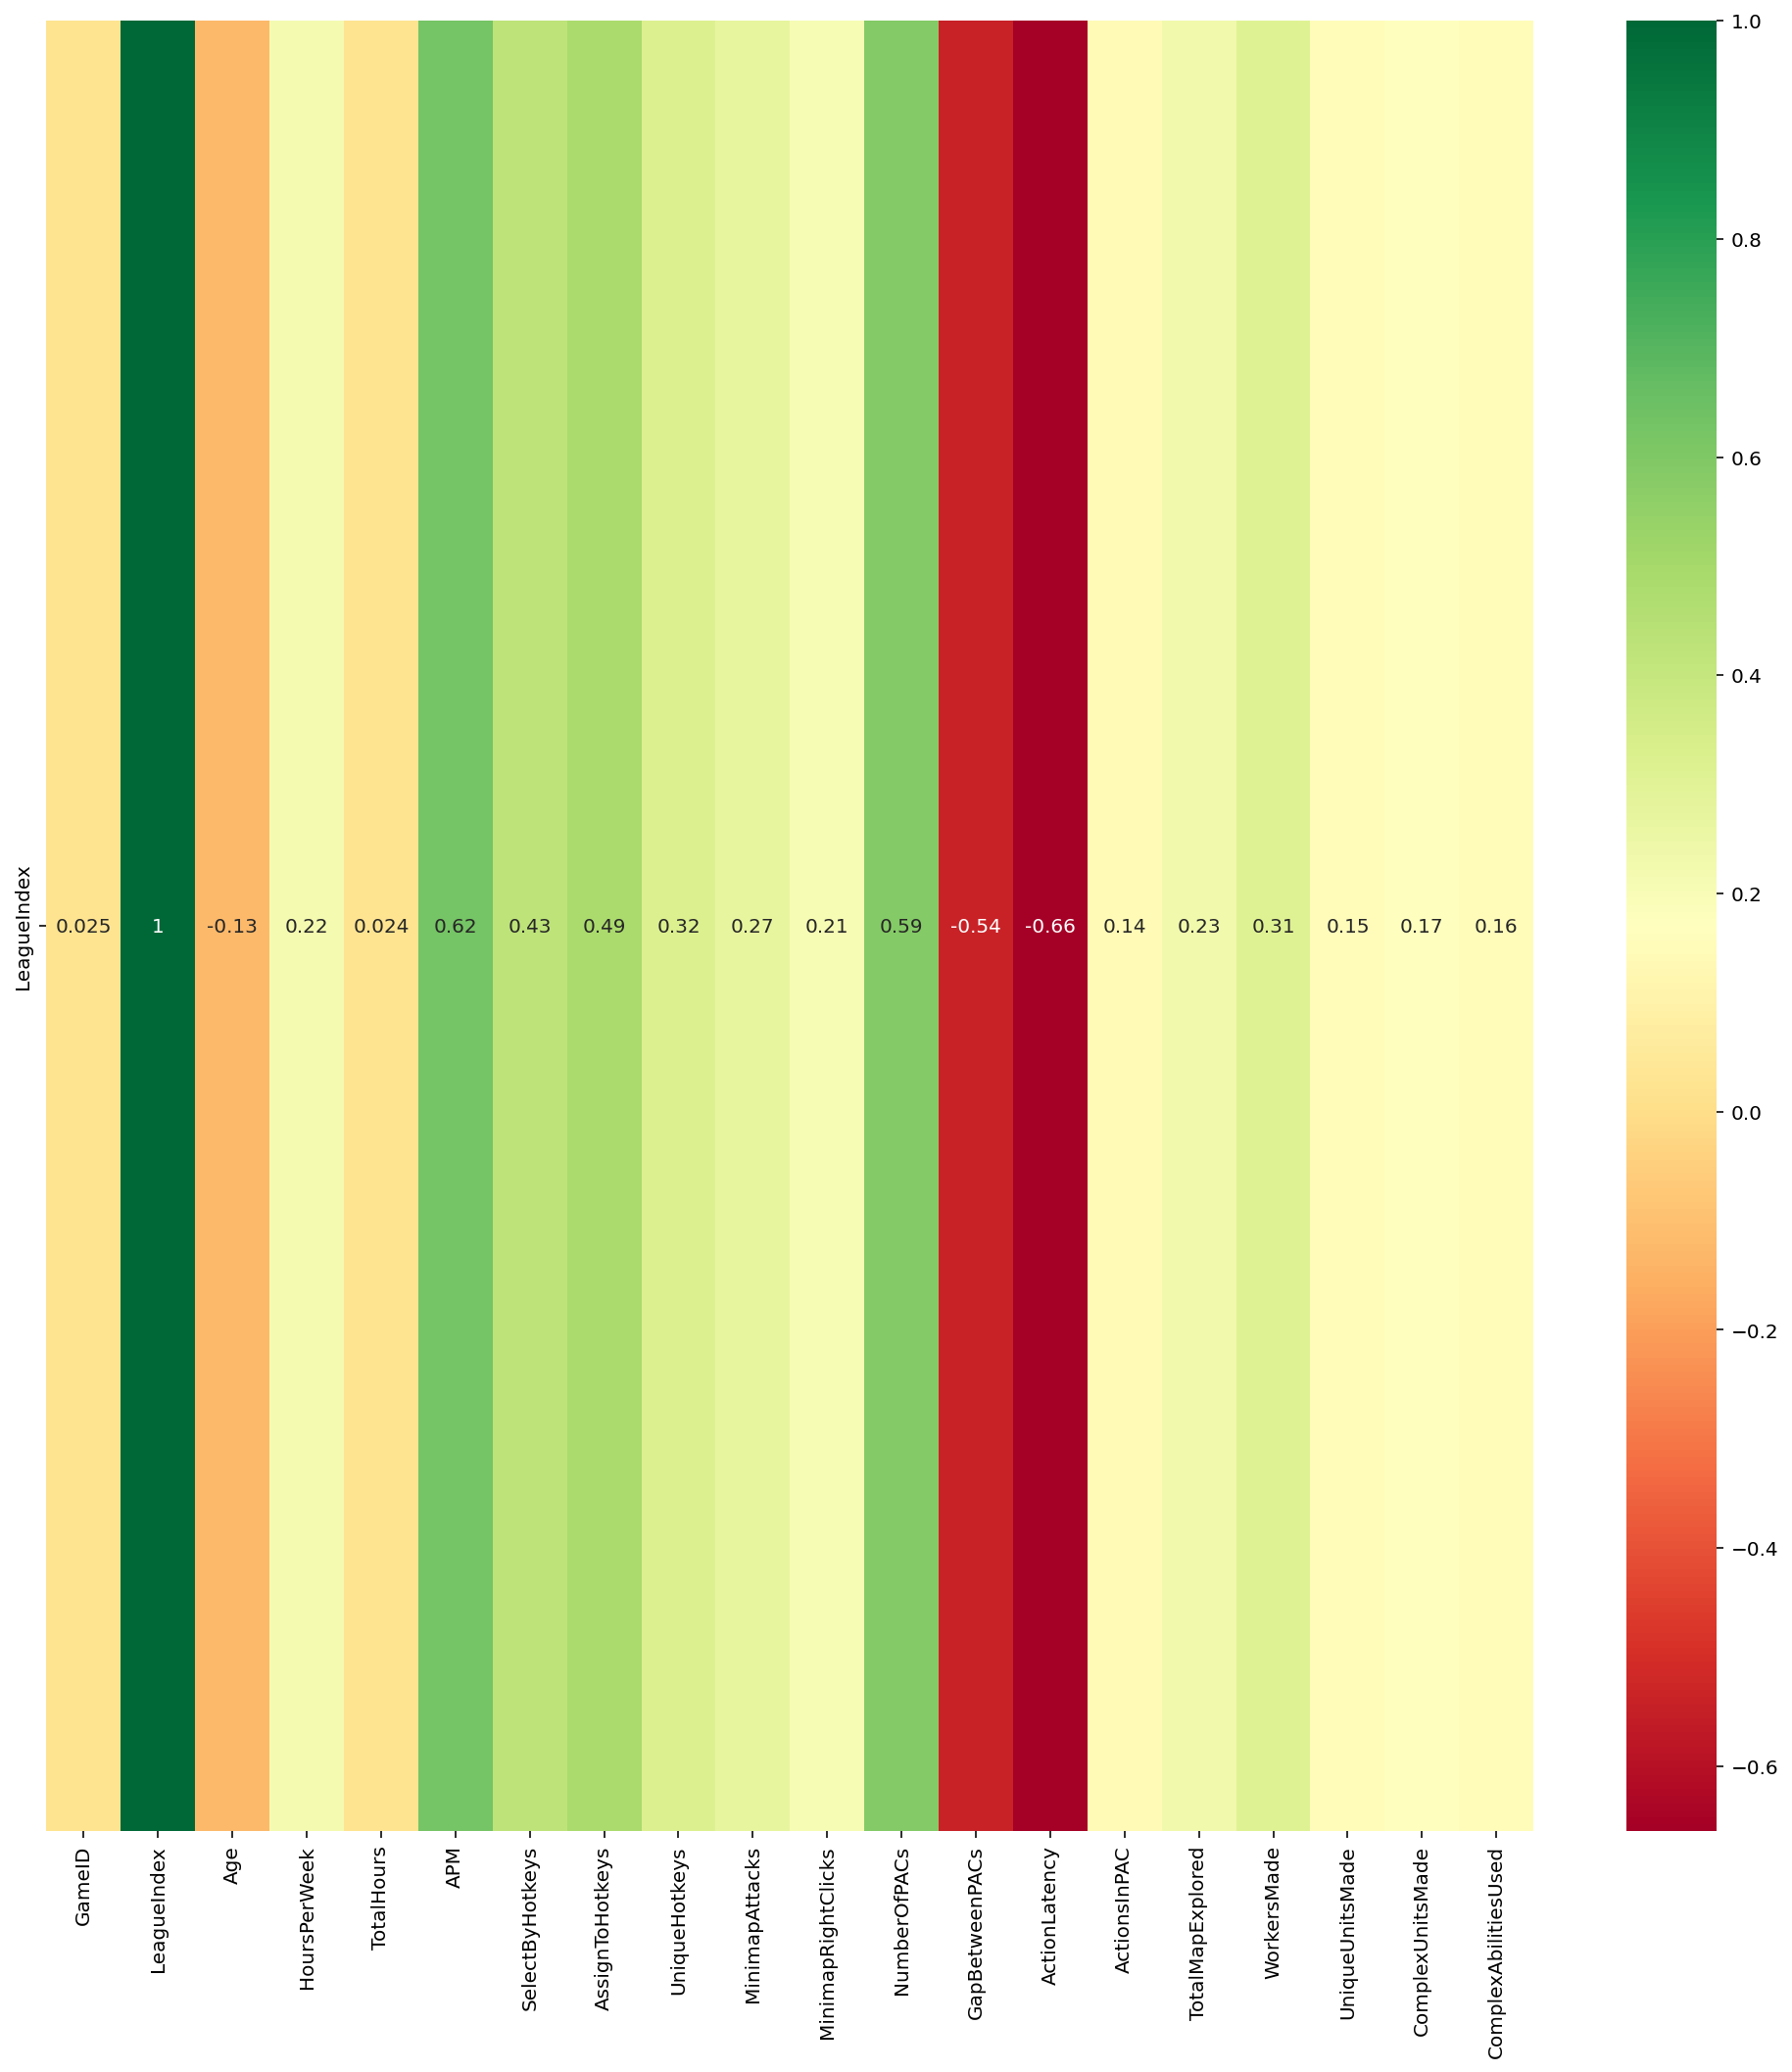

In [52]:
plt.figure(figsize=(17,17))
sns.heatmap(dataset.corr().loc[['LeagueIndex'],:], annot=True,cmap="RdYlGn")

<Axes: >

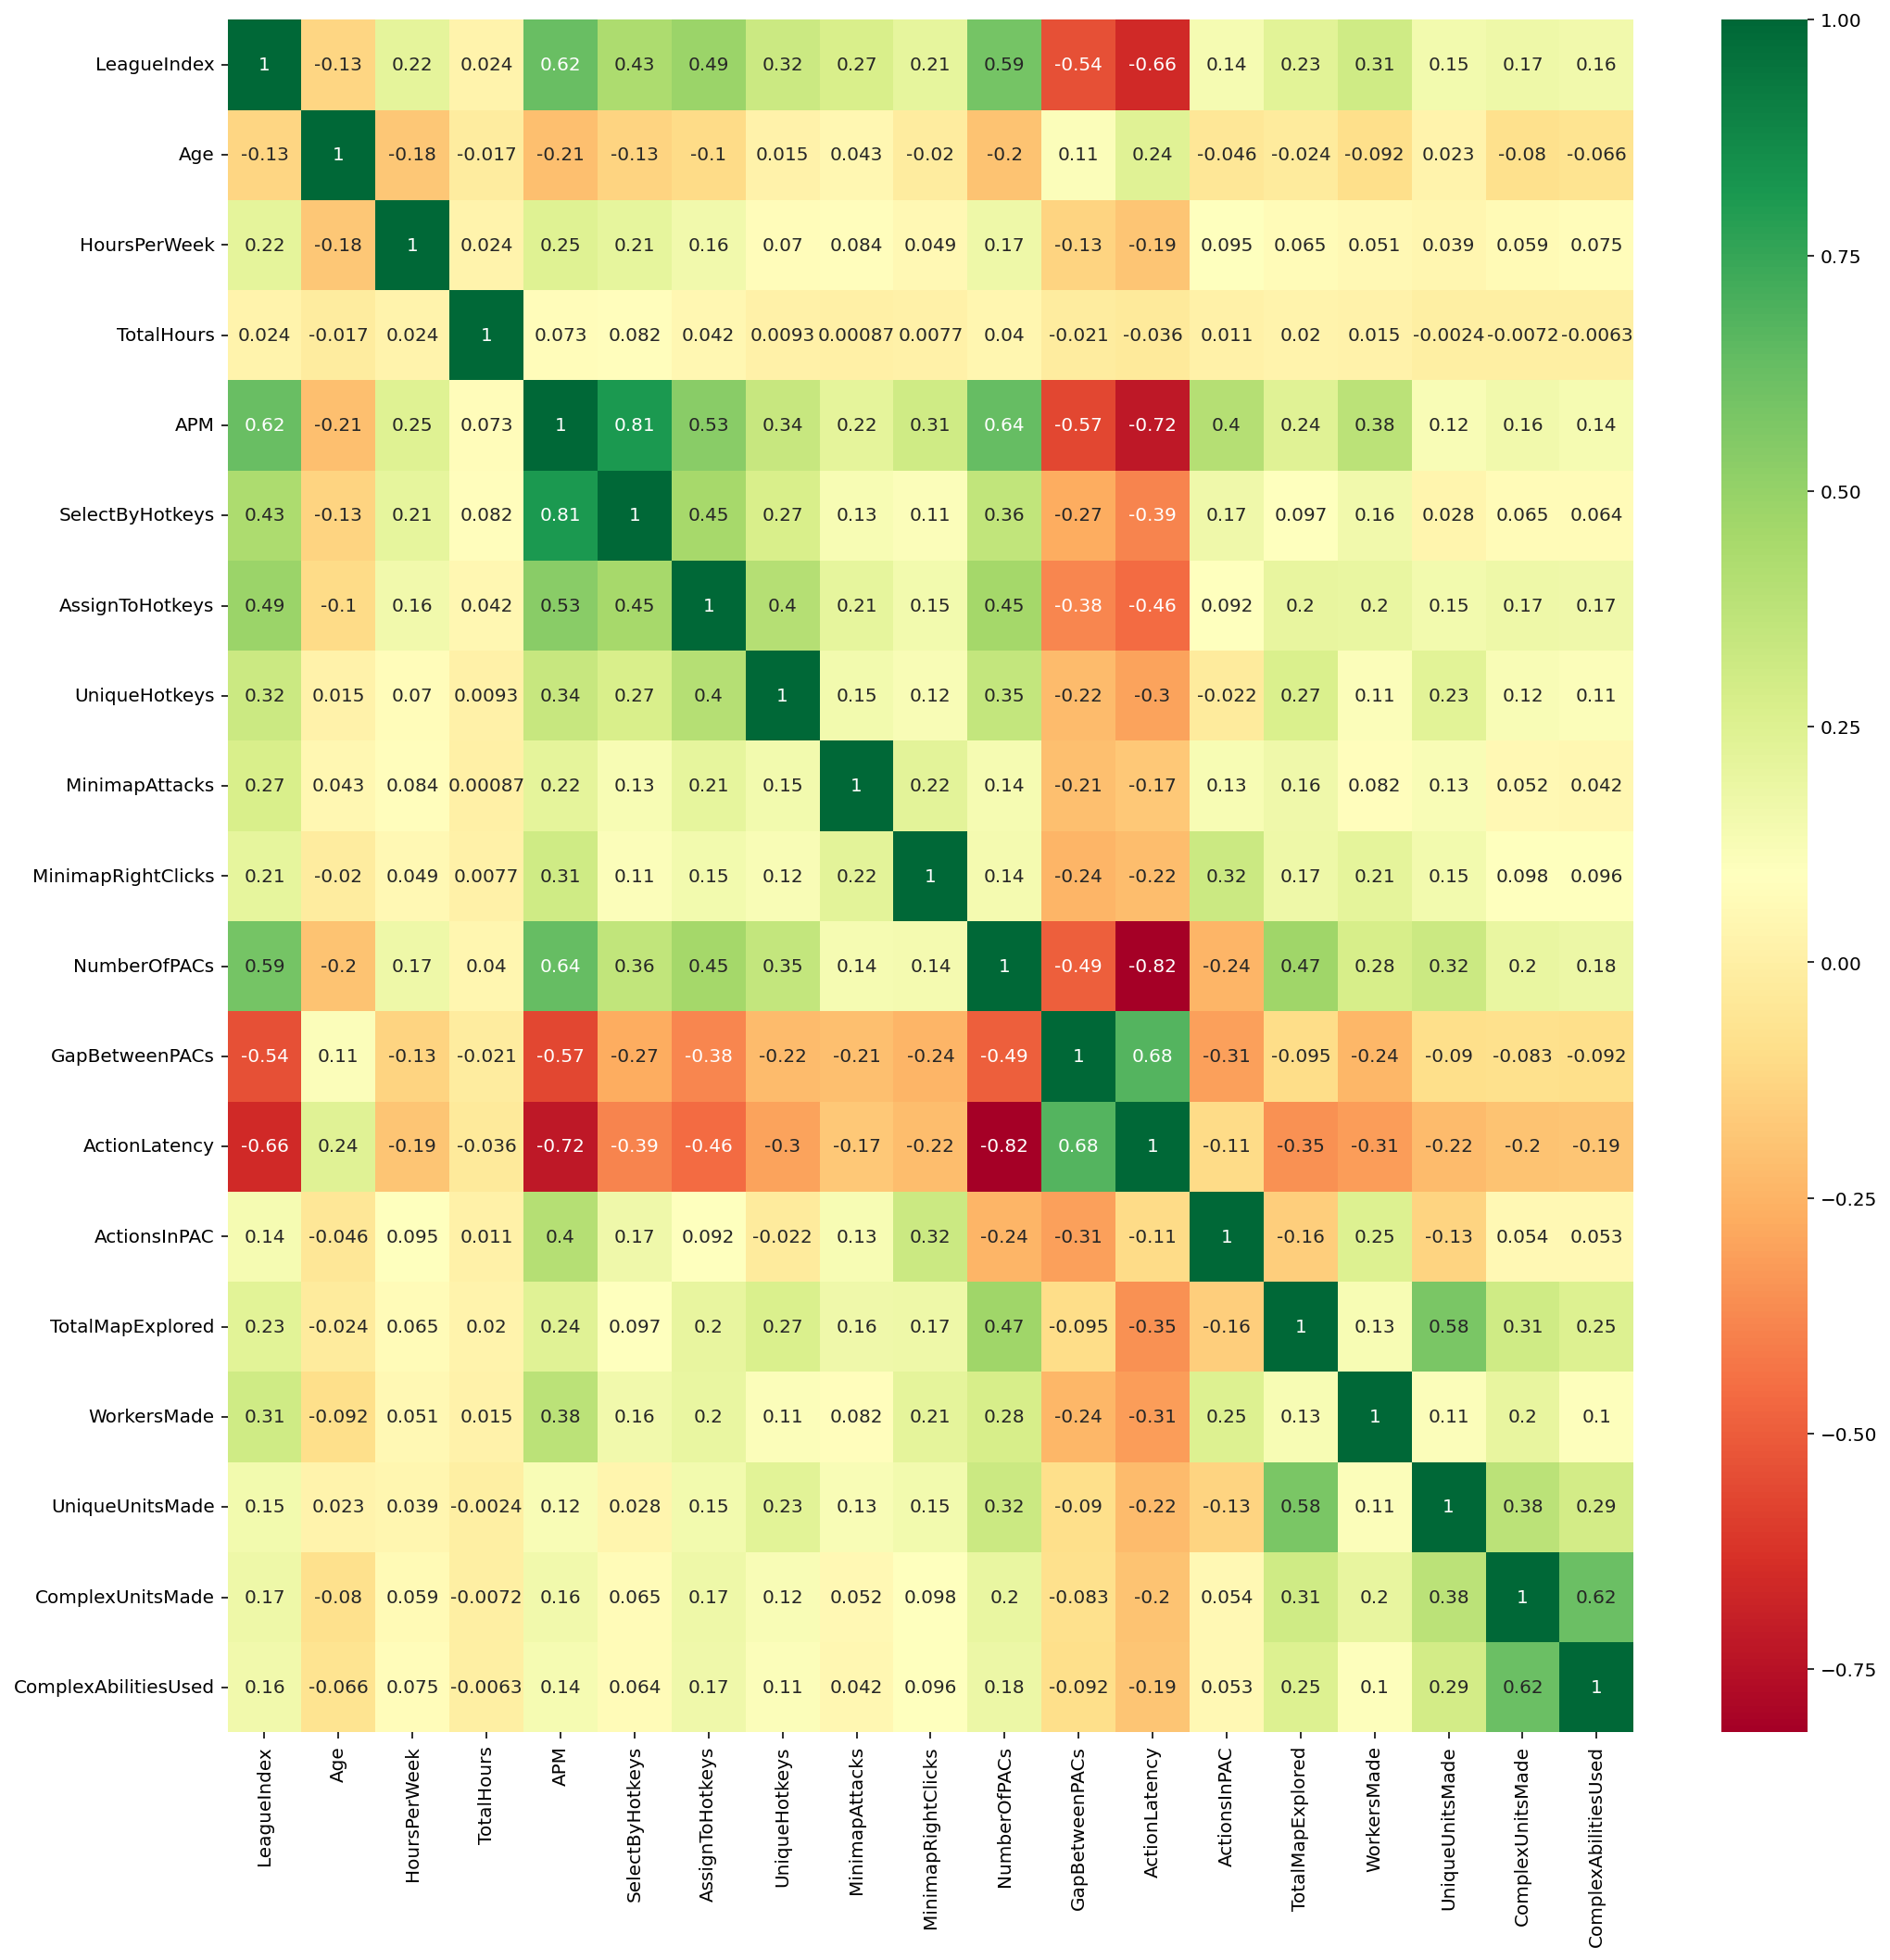

In [53]:
plt.figure(figsize=(17,17))
sns.heatmap(dataset.loc[:, dataset.columns!='GameID'].corr(),annot=True,cmap="RdYlGn")

# Part 3: Further Data Transformations

## Part 3.1: Feature Scaling (Min-Max Scaling)

* We noticed that many attributes are not normalized. As many modeling options do not behave well with non-normalized data, we decided to use Scikit-Learn's min-max scaler.

In [54]:
Y = dataset['LeagueIndex']

# Scaling data.
sk_scaler=MinMaxScaler()

dataset_scaled=sk_scaler.fit_transform(dataset)
new_dataset=pd.DataFrame(dataset_scaled,columns=dataset.columns)
dataset=new_dataset

# Part 4: Choosing Model (Random Forest)

In [55]:
X = dataset
X = X.drop(['GameID'],axis=1)
X = X.drop(['LeagueIndex'],axis=1)

# Building sets for training.
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state=12,stratify=Y)

# Training random forest classifier.
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train,y_train)

# Assessing accuracy of the model.
print('Accuracy = ', random_forest.score(x_test,y_test))

Accuracy =  0.3972055888223553


# Part 5: Closing Remarks

## 5.1: How Would I Collect More Data?

* We would recommend gathering more data for the upper ranks.